# 🌪️ Project Title: Cyclone Intensity Prediction

## Problem Statement
Cyclones cause severe damage to life and property. Predicting their intensity in advance can help in disaster preparedness, evacuation, and early warning systems.  

## Description
This project uses the Atlantic Hurricane dataset to predict cyclone intensity.  
It applies **Random Forest** for classification (Cyclone vs Not Cyclone) and **LSTM** for time-series forecasting (next wind speed prediction).  

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns 

In [41]:
df = pd.read_csv("Downloads/atlantic.csv")   # make sure atlantic.csv is in same folder as notebook
print("✅ Dataset loaded successfully!")
df.info()
print("Columns available:", df.columns.tolist())
df.head()

✅ Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [42]:
print(df.isnull().sum())

ID                  0
Name                0
Date                0
Time                0
Event               0
Status              0
Latitude            0
Longitude           0
Maximum Wind        0
Minimum Pressure    0
Low Wind NE         0
Low Wind SE         0
Low Wind SW         0
Low Wind NW         0
Moderate Wind NE    0
Moderate Wind SE    0
Moderate Wind SW    0
Moderate Wind NW    0
High Wind NE        0
High Wind SE        0
High Wind SW        0
High Wind NW        0
dtype: int64


Numeric columns being used for correlation: ['Date', 'Time', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']


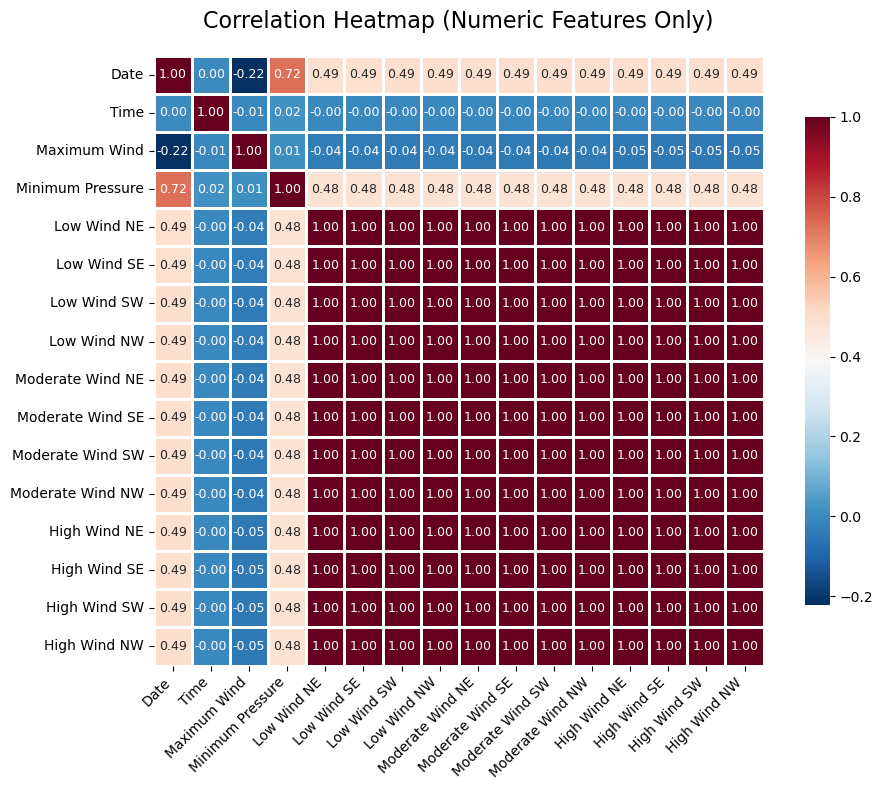

In [43]:
# Select only numeric columns explicitly
numeric_df = df.select_dtypes(include=["int64", "float64"])

print("Numeric columns being used for correlation:", numeric_df.columns.tolist())

# Compute correlation only on numeric data
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))  # larger figure size
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",                # 2 decimal places
    cmap="RdBu_r",            # red=negative, blue=positive
    cbar_kws={"shrink": 0.8}, # smaller color bar
    square=True,              # square cells
    linewidths=0.8,           # white grid lines
    linecolor="white",
    annot_kws={"size": 9}     # smaller text inside cells
)

plt.title("Correlation Heatmap (Numeric Features Only)", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

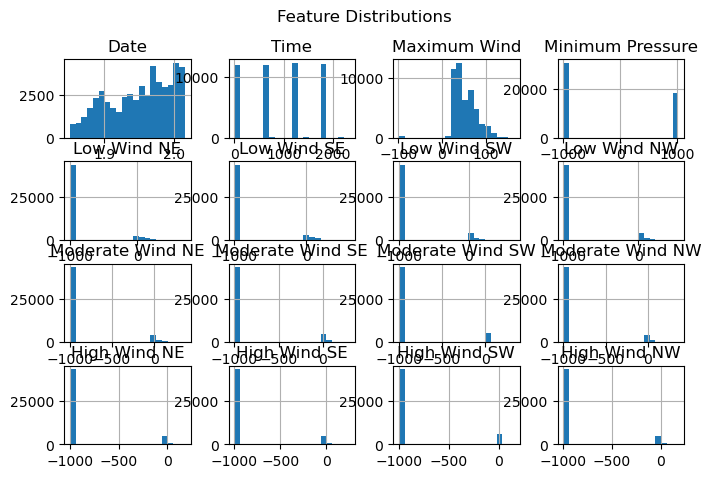

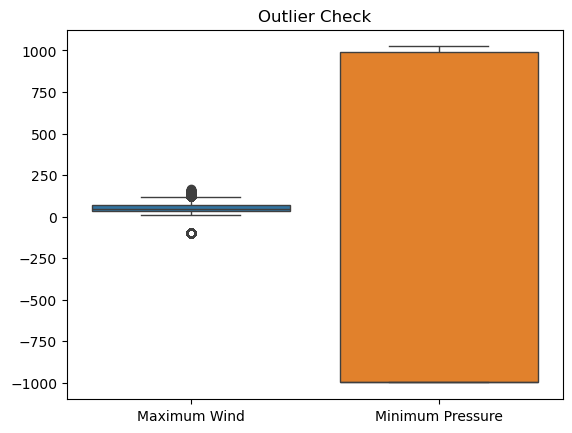

In [44]:
# Histograms
# Histogram → See distributions (are wind speeds skewed? pressures normal?)
df.hist(figsize=(8,5), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

# Boxplots (for outliers)
# Boxplot → Detect outliers.
sns.boxplot(data=df[["Maximum Wind", "Minimum Pressure"]])
plt.title("Outlier Check")
plt.show()


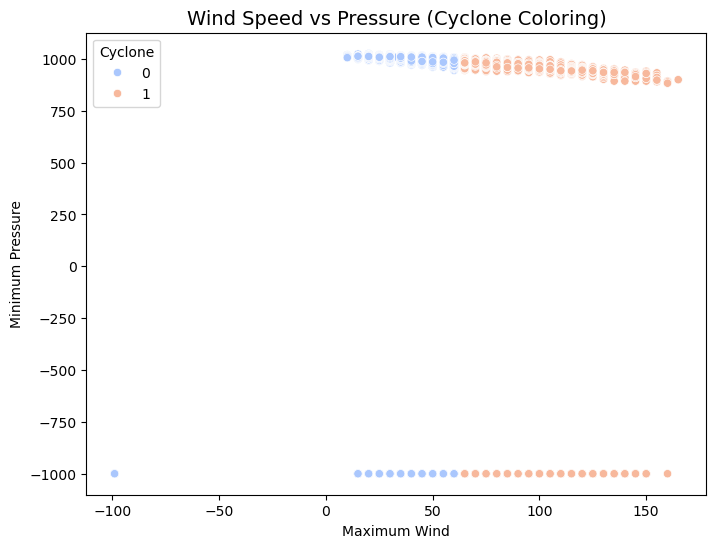

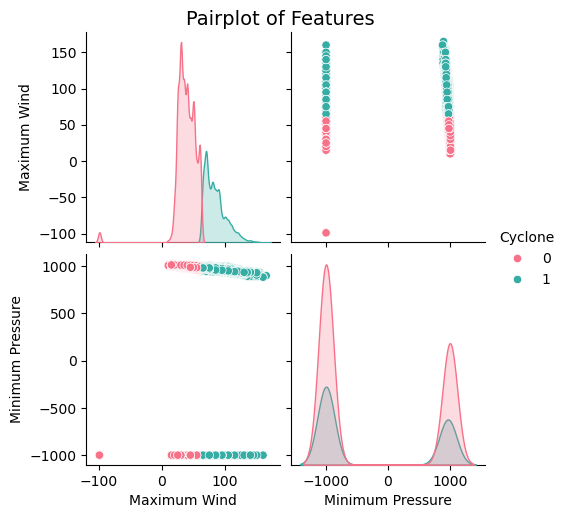

In [56]:
# Scatter Plot (Wind vs Pressure)
plt.figure(figsize=(8,6))
sns.scatterplot(x="Maximum Wind", y="Minimum Pressure", hue="Cyclone", data=df, palette="coolwarm")
plt.title("Wind Speed vs Pressure (Cyclone Coloring)", fontsize=14)
plt.show()

# Pairplot (Scatter Matrix)
sns.pairplot(df[["Maximum Wind", "Minimum Pressure", "Cyclone"]], hue="Cyclone", palette="husl")
plt.suptitle("Pairplot of Features", y=1.02, fontsize=14)
plt.show()

Columns in df: ['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude', 'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW', 'Cyclone']


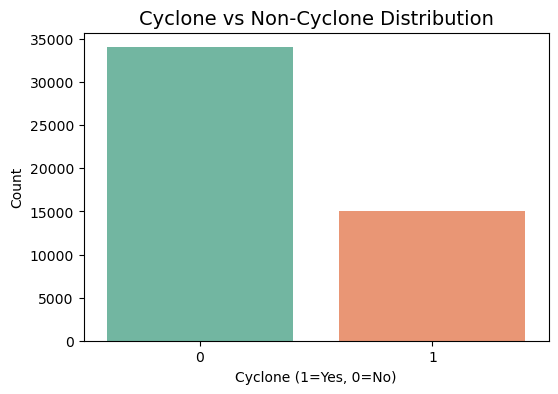

In [46]:
# Ensure Cyclone column exists
# Countplot → Class balance (Cyclone vs Non-Cyclone).
if "Cyclone" not in df.columns:
    df["Cyclone"] = (df["Maximum Wind"] >= 64).astype(int)

print("Columns in df:", df.columns.tolist())

# Now plot
plt.figure(figsize=(6,4))
sns.countplot(x="Cyclone", hue="Cyclone", data=df, palette="Set2", legend=False)
plt.title("Cyclone vs Non-Cyclone Distribution", fontsize=14)
plt.xlabel("Cyclone (1=Yes, 0=No)")
plt.ylabel("Count")
plt.show()


In [47]:
# Data Transformation
# 1. Handle missing values (if any)
df = df.dropna()

# 2. Scaling numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[["Maximum Wind", "Minimum Pressure"]])

# 3. Convert back to DataFrame for readability
X = pd.DataFrame(X_scaled, columns=["Maximum Wind (scaled)", "Minimum Pressure (scaled)"])
y = (df["Maximum Wind"] >= 64).astype(int)   # Cyclone label

# 4. Show results
print("✅ Original Features (first 5 rows):")
print(df[["Maximum Wind", "Minimum Pressure"]].head())

print("\n✅ Scaled Features (first 5 rows):")
print(X.head())

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)


✅ Original Features (first 5 rows):
   Maximum Wind  Minimum Pressure
0            80              -999
1            80              -999
2            80              -999
3            80              -999
4            80              -999

✅ Scaled Features (first 5 rows):
   Maximum Wind (scaled)  Minimum Pressure (scaled)
0               1.011318                  -0.775267
1               1.011318                  -0.775267
2               1.011318                  -0.775267
3               1.011318                  -0.775267
4               1.011318                  -0.775267

Shape of X: (49105, 2)
Shape of y: (49105,)


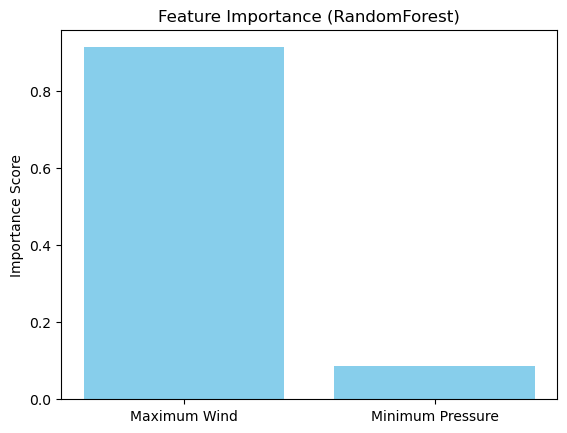

In [48]:
# Feature Selection

temp_rf = RandomForestClassifier(n_estimators=100, random_state=42)
temp_rf.fit(X, y)

# Feature importance
importances = temp_rf.feature_importances_
feat_names = ["Maximum Wind", "Minimum Pressure"]

# Plot importance
plt.bar(feat_names, importances, color="skyblue")
plt.title("Feature Importance (RandomForest)")
plt.ylabel("Importance Score")
plt.show()

In [49]:
df = df[["Maximum Wind", "Minimum Pressure"]].dropna()
df["Cyclone"] = (df["Maximum Wind"] >= 64).astype(int)

print("✅ Processed dataset:")
df.head()


✅ Processed dataset:


,Maximum Wind,Minimum Pressure,Cyclone
0,80,-999,1
1,80,-999,1
2,80,-999,1
3,80,-999,1
4,80,-999,1


In [50]:
X = df[["Maximum Wind", "Minimum Pressure"]]
y = df["Cyclone"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

print("✅ ML Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ ML Model Evaluation:
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6796
           1       1.00      1.00      1.00      3025

    accuracy                           1.00      9821
   macro avg       1.00      1.00      1.00      9821
weighted avg       1.00      1.00      1.00      9821



In [52]:
new_input1 = pd.DataFrame([{"Maximum Wind": 85, "Minimum Pressure": 970}])
new_input2 = pd.DataFrame([{"Maximum Wind": 30, "Minimum Pressure": 1012}])

print("Prediction 1:", "Cyclone" if model_rf.predict(new_input1)[0] else "Not Cyclone")
print("Prediction 2:", "Cyclone" if model_rf.predict(new_input2)[0] else "Not Cyclone")


Prediction 1: Cyclone
Prediction 2: Not Cyclone


In [53]:
# Normalize wind speed values
wind_series = df["Maximum Wind"].values.astype(float)

# Scale between 0 and 1
wind_series = (wind_series - wind_series.min()) / (wind_series.max() - wind_series.min())

# Reshape to (n_samples, 1) before using TimeseriesGenerator
wind_series = wind_series.reshape(-1, 1)

# Sequence length for LSTM
seq_length = 10

# Create generator
generator = TimeseriesGenerator(wind_series, wind_series, length=seq_length, batch_size=32)

print("✅ Number of sequences generated:", len(generator))

# Define model
model_lstm = Sequential([
    LSTM(64, activation="tanh", input_shape=(seq_length, 1)),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer="adam", loss="mse")

# Train model
history = model_lstm.fit(generator, epochs=5, verbose=1)


✅ Number of sequences generated: 1535
Epoch 1/5


C:\Users\rakes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\rakes\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1535/1535 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0061
Epoch 2/5
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0024
Epoch 3/5
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0018
Epoch 4/5
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0014
Epoch 5/5
1535/1535 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0012    


In [54]:
# Take the last 10 timesteps for prediction
last_seq = wind_series[-seq_length:].reshape((1, seq_length, 1))

# Predict next wind value
next_wind = model_lstm.predict(last_seq)[0][0]

# Convert back to original scale
predicted_wind = next_wind * (df["Maximum Wind"].max() - df["Maximum Wind"].min()) + df["Maximum Wind"].min()

print(f"✅ AI Predicted Next Wind Speed: {predicted_wind:.2f} knots")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
✅ AI Predicted Next Wind Speed: 44.88 knots
